# Build Transformer with PyTorch

In [1]:
!pip install nltk
!pip install gensim


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
import torch

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

<span style='color:blue'>Load Dataset</span>

In [4]:
train_df = pd.read_csv('ag_news_csv/train.csv', header=None)
test_df = pd.read_csv('ag_news_csv/test.csv', header=None)

In [5]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
df.columns = ['label', 'headline', 'content']

<span style='color:blue'>Info about dataset</span>

In [6]:
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (127600, 3)


<span style='color:blue'>First 5 reviews</span>

In [7]:
df.head()

,label,headline,content
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


<span style='color:blue'>Basic Statistics</span>

In [8]:
df['headline_length'] = df['headline'].apply(len)
df['content_length'] = df['content'].apply(len)
print(df[['headline_length', 'content_length']].describe())

       headline_length  content_length
count    127600.000000   127600.000000
mean         42.064530      193.342813
std          13.558026       64.377881
min           6.000000       20.000000
25%          33.000000      155.000000
50%          41.000000      188.000000
75%          49.000000      219.000000
max         115.000000      985.000000


In [9]:
def count_words(text):
    return len(re.findall(r'\b\w+\b', text))

df['headline_word_count'] = df['headline'].apply(count_words)
df['content_word_count'] = df['content'].apply(count_words)

In [10]:
print(df[['headline_word_count', 'content_word_count']].describe())

       headline_word_count  content_word_count
count        127600.000000       127600.000000
mean              7.175321           32.471215
std               2.536207           11.059367
min               1.000000            3.000000
25%               6.000000           26.000000
50%               7.000000           31.000000
75%               8.000000           37.000000
max              24.000000          177.000000


<span style='color:blue'>Visualization 1: Rating distribution plot</span>

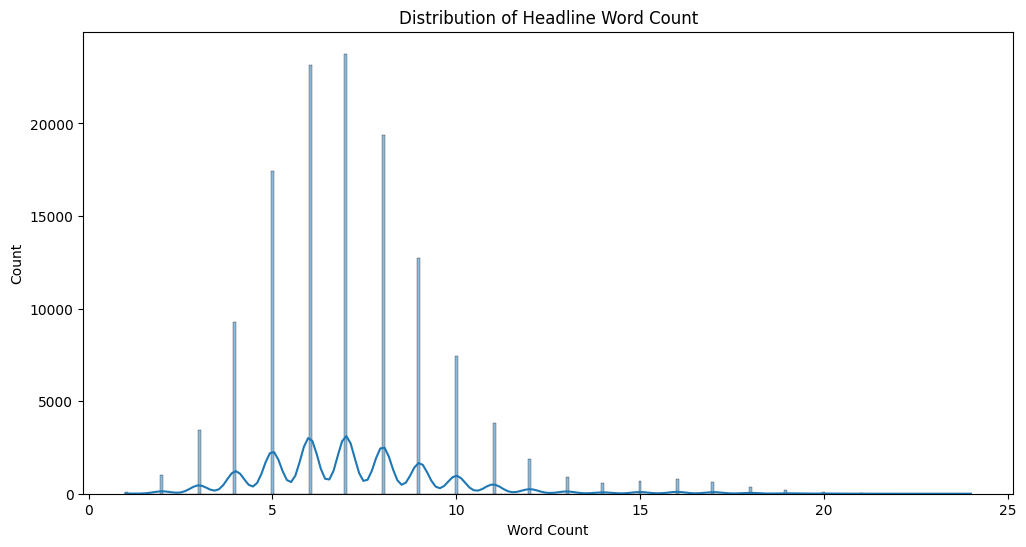

In [77]:
plt.figure(figsize=(12, 6))
sns.histplot(df['headline_word_count'], kde=True)
plt.title('Distribution of Headline Word Count')
plt.xlabel('Word Count')
plt.show()

<span style='color:green'>The plot shows the distribution of headline word counts, with most headlines having 5 to 10 words. Peaks occur around 6 to 7 words, making them the most common lengths. Headlines longer than 15 words are rare.</span>

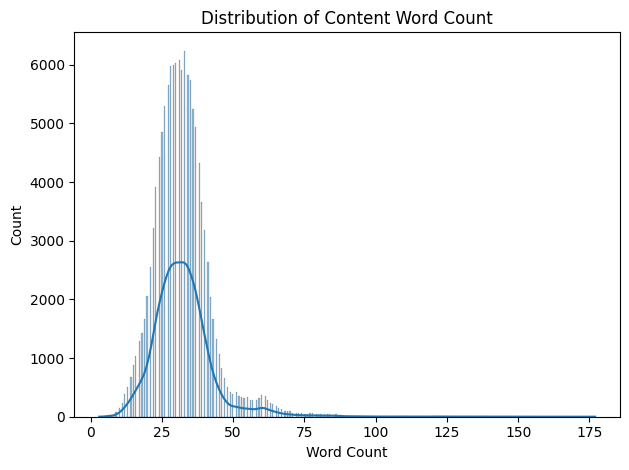

In [78]:
sns.histplot(df['content_word_count'], kde=True)
plt.title('Distribution of Content Word Count')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

<span style='color:green'>This plot shows the distribution of content word counts. Most content pieces are around 30 to 50 words, with a sharp peak near 35 words. Word counts above 80 are rare, and the overall shape is right-skewed, indicating some longer content but mostly short to medium-length entries.</span>

<span style='color:blue'>Visualization 2: Word Count Distribution by Rating</span>

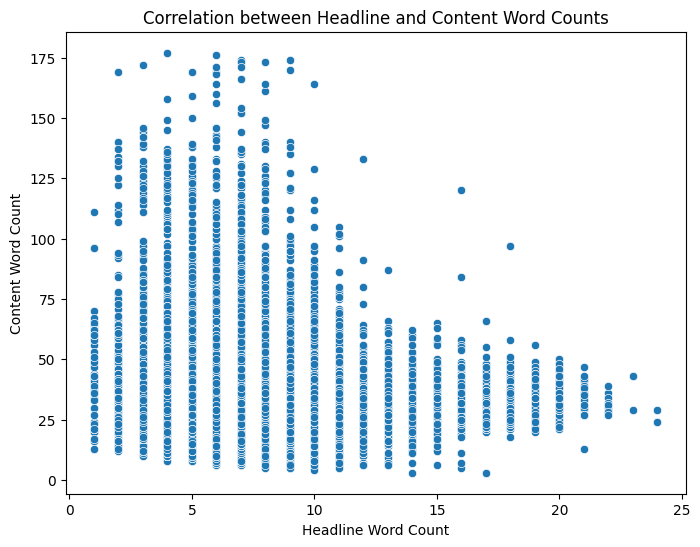

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='headline_word_count', y='content_word_count', data=df)
plt.title('Correlation between Headline and Content Word Counts')
plt.xlabel('Headline Word Count')
plt.ylabel('Content Word Count')
plt.show()

<span style='color:green'>This scatter plot shows the correlation between headline and content word counts. There’s no strong linear relationship while short headlines (5–10 words) often link to longer content (50–150 words), longer headlines don’t necessarily imply longer content. Most points are concentrated in the lower headline range but spread widely in content word count.</span>

<span style='color:blue'>Visualization 3: Review Length Distribution</span>

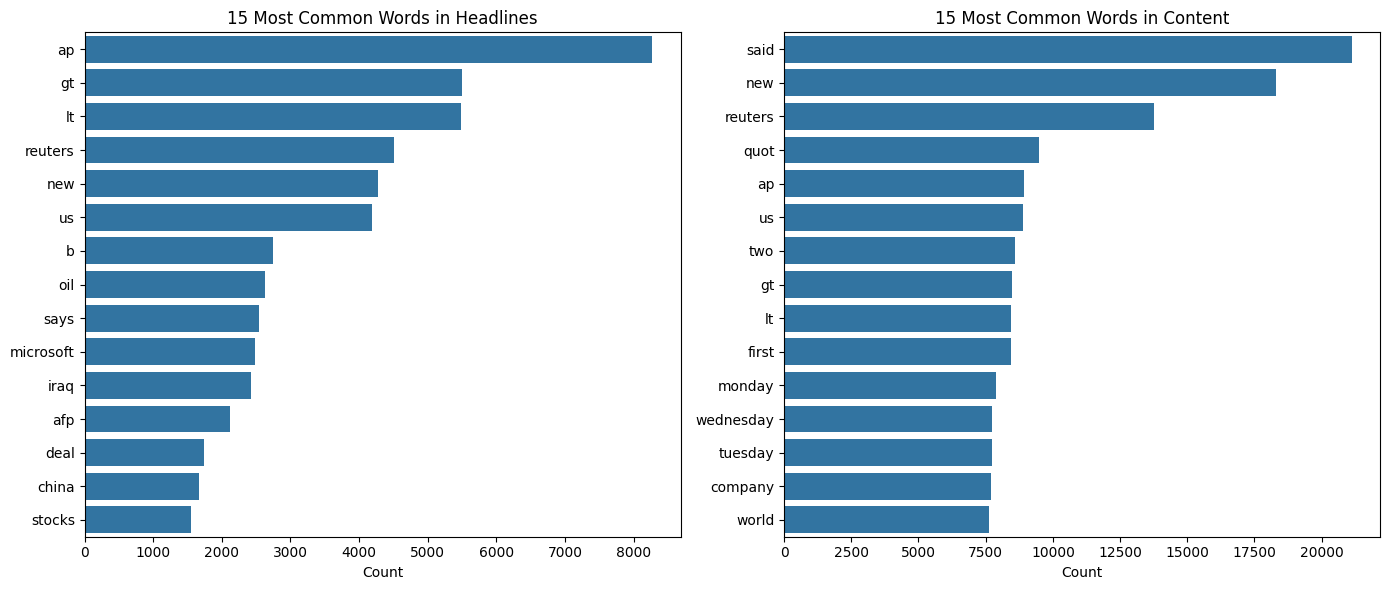

In [14]:
def get_most_common_words(texts, top_n=20):
    all_words = []
    stop_words = set(stopwords.words('english'))
    
    for text in texts:
        words = word_tokenize(text.lower())
        words = [word for word in words if word.isalpha() and word not in stop_words]
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

common_headline_words = get_most_common_words(df['headline'], 15)
common_content_words = get_most_common_words(df['content'], 15)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
words, counts = zip(*common_headline_words)
sns.barplot(x=list(counts), y=list(words))
plt.title('15 Most Common Words in Headlines')
plt.xlabel('Count')

plt.subplot(1, 2, 2)
words, counts = zip(*common_content_words)
sns.barplot(x=list(counts), y=list(words))
plt.title('15 Most Common Words in Content')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

<span style='color:green'>The most common words in both headlines and content include ap, gt, lt, reuters, and us. Content also features contextual words like said, new, and weekdays, while headlines contain more source-related terms.</span>

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

<span style='color:blue'>Text Cleaning, Lowercasing and Tokenization</span>

In [15]:
def preprocess_text(text):
    # Text lowercasing
    text = text.lower()
    
    # Remove punctuation and unnecessary characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

In [16]:
df['processed_headline'] = df['headline'].apply(preprocess_text)
df['processed_content'] = df['content'].apply(preprocess_text)

In [17]:
for i in range(min(3, len(df))):
    print(f"Original: {df.iloc[i]['headline'][:100]}...")
    print(f"Processed: {df.iloc[i]['processed_headline'][:100]}...")

Original: Wall St. Bears Claw Back Into the Black (Reuters)...
Processed: ['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters']...
Original: Carlyle Looks Toward Commercial Aerospace (Reuters)...
Processed: ['carlyle', 'looks', 'toward', 'commercial', 'aerospace', 'reuters']...
Original: Oil and Economy Cloud Stocks' Outlook (Reuters)...
Processed: ['oil', 'economy', 'cloud', 'stocks', 'outlook', 'reuters']...


<span style='color:blue'>Vocabulary Building</span>

In [18]:
def build_vocabulary(processed_texts):
    vocab = set()
    for text in processed_texts:
        vocab.update(text)
    return vocab

In [19]:
headline_vocab = build_vocabulary(df['processed_headline'])
content_vocab = build_vocabulary(df['processed_content'])
combined_vocab = headline_vocab.union(content_vocab)

In [20]:
print(f"\nHeadline vocabulary size: {len(headline_vocab)}")
print(f"Content vocabulary size: {len(content_vocab)}")
print(f"Combined vocabulary size: {len(combined_vocab)}")


Headline vocabulary size: 42392
Content vocabulary size: 95835
Combined vocabulary size: 105145


<span style='color:blue'>Combine Tokens</span>

In [21]:
combined_tokens = df['processed_headline'].tolist() + df['processed_content'].tolist()

<span style='color:blue'>Word embedding example using Gensim's Word2Vec</span>

In [22]:
word2vec_model = Word2Vec(combined_tokens, vector_size=100, window=5, min_count=1, workers=4)
sample_word = list(combined_vocab)[0]
word_vector = word2vec_model.wv[sample_word]

print(f"\nExample word embedding for '{sample_word}':")
print(f"Vector shape: {word_vector.shape}")
print(f"Vector preview: {word_vector[:5]}...")


Example word embedding for 'quotblazoned':
Vector shape: (100,)
Vector preview: [-0.01363663  0.01860802  0.01588508 -0.01199542  0.00497107]...


<span style='color:blue'>Create word-to-index mapping</span>

In [23]:
word_to_idx = {word: idx + 1 for idx, word in enumerate(combined_vocab)}

In [24]:
def tokens_to_indices(tokens, word_to_idx):
    return [word_to_idx.get(token, 0) for token in tokens]

In [25]:
df['headline_indices'] = df['processed_headline'].apply(lambda x: tokens_to_indices(x, word_to_idx))
df['content_indices'] = df['processed_content'].apply(lambda x: tokens_to_indices(x, word_to_idx))

In [26]:
texts = df['content_indices'].tolist()
labels = df['label'].tolist()

<span style='color:blue'>Embedding Matrix</span>

In [27]:
vocab_size = len(word_to_idx) + 1
embedding_dim = word2vec_model.vector_size

In [28]:
embedding_matrix = torch.zeros((vocab_size, embedding_dim))
for word, idx in word_to_idx.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = torch.tensor(word2vec_model.wv[word])

## Step 2: Model Construction

In [ ]:
import torch
import torch.nn as nn
import math
from torchinfo import summary

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=512):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

In [31]:
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=256,
        num_classes=1,
        max_seq_length=512,
        num_encoder_layers=3,
        num_heads=8,
        dropout=0.1,
        dim_feedforward=512,
        pretrained_embeddings=None
    ):
        super(TransformerClassifier, self).__init__()
        
        # Embedding layer
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings, 
                freeze=False,
                padding_idx=0
            )
        else:
            self.embedding = nn.Embedding(
                vocab_size, 
                embedding_dim,
                padding_idx=0
            )
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(embedding_dim, max_seq_length)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )

        self.norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Output layer for classification
        self.classifier = nn.Linear(embedding_dim, num_classes)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                if 'embedding' in name and isinstance(self.embedding, nn.Embedding) and self.embedding.weight.requires_grad:
                    nn.init.normal_(p, mean=0, std=0.02)
                else:
                    nn.init.xavier_uniform_(p)
                
    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        encoded = self.transformer_encoder(x, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        pooled = encoded[:, 0, :]
        pooled = self.norm(pooled)
        pooled = self.dropout(pooled)
        output = self.classifier(pooled)      
        return output

3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

4.	Print model summary using torchinfo.summary

In [32]:
batch_size = 32
max_seq_length = min(128, max(len(seq) for seq in texts))

In [33]:
num_classes = len(np.unique(labels))
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim, 
    num_classes=num_classes,
    max_seq_length=max_seq_length,
    num_encoder_layers=2,
    num_heads=4,
    dropout=0.5,
    dim_feedforward=128,
    pretrained_embeddings=embedding_matrix
)

In [34]:
dummy_input = torch.randint(0, model.embedding.num_embeddings, (batch_size, max_seq_length))
summary(model, input_data=[dummy_input], device="cpu")

Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifier                         [32, 4]                   --
├─Embedding: 1-1                              [32, 95, 100]             10,514,600
├─PositionalEncoding: 1-2                     [32, 95, 100]             --
├─TransformerEncoder: 1-3                     [32, 95, 100]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 95, 100]             66,628
│    │    └─TransformerEncoderLayer: 3-2      [32, 95, 100]             66,628
├─LayerNorm: 1-4                              [32, 100]                 200
├─Dropout: 1-5                                [32, 100]                 --
├─Linear: 1-6                                 [32, 4]                   404
Total params: 10,648,460
Trainable params: 10,648,460
Non-trainable params: 0
Total mult-adds (M): 338.17
Input size (MB): 0.02
Forward/backward pass si

5. Briefly describe the Transformer architecture you have defined.

<span style='color:green'>

The defined architecture is a Transformer-based text classifier that uses embedding + positional encoding + transformer encoder layers followed by classification. 

* Embedding Layer: Converts input tokens into dense vectors. If pretrained_embeddings are provided, it loads and fine-tunes them.

* Positional Encoding: Adds positional information using sine and cosine functions to the embeddings, helping the model understand word order.

* Transformer Encoder: Consists of multiple encoder layers with multi-head self-attention, feedforward networks, dropout, and layer normalization.

    - Multi-Head Self-Attention: Allows the model to focus on different parts of the sequence.
    - Feedforward Layer: A fully connected layer applied to each position.
    - Dropout: Helps prevent overfitting.
    - LayerNorm: Stabilizes training by normalizing intermediate outputs.

* Pooling: Takes the representation of the first token (index 0) as the summary vector. This acts like a [CLS] token used in BERT-style models.

* Classifier: A linear layer maps the pooled output to the number of target classes.

* Regularization: Dropout and LayerNorm are used to prevent overfitting and stabilize training.

* Weight Initialization: Embedding weights are initialized with normal distribution if trainable. Other weights use Xavier Uniform initialization for stable training.

The model is flexible, supports pretrained embeddings, and is designed for sequence classification tasks.

</span>

## Step 3: Training the Transformer

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [36]:
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [37]:
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 89320
Validation samples: 19140
Testing samples: 19140


In [38]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, max_length=128):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Pad/truncate sequence
        if len(text) > self.max_length:
            input_ids = text[:self.max_length]
        else:
            input_ids = text + [0] * (self.max_length - len(text))
        
        # Convert to tensors
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_mask = torch.ones_like(input_ids).float()
        attention_mask[input_ids == 0] = 0.0
        
        # Convert label to tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label_tensor
        }

In [39]:
train_dataset = TextClassificationDataset(X_train, y_train, max_length=max_seq_length)
val_dataset = TextClassificationDataset(X_val, y_val, max_length=max_seq_length)
test_dataset = TextClassificationDataset(X_test, y_test, max_length=max_seq_length)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [41]:
num_classes = len(np.unique(labels))
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim, 
    num_classes=num_classes,
    max_seq_length=max_seq_length,
    num_encoder_layers=2,
    num_heads=4,
    dropout=0.5,
    dim_feedforward=128,
    pretrained_embeddings=embedding_matrix
)

In [42]:
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [43]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device = torch.device('cpu')
print(f"Using device: {device}")
num_epochs = 10

Using device: cpu


In [44]:
def create_padding_mask(src, pad_idx=0):
    return (src == pad_idx)

In [45]:
model.to(device)
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        src_key_padding_mask = create_padding_mask(input_ids).to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, src_key_padding_mask=src_key_padding_mask)
        loss = loss_function(outputs, labels - 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        predicted = predicted + 1
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    # val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            src_key_padding_mask = create_padding_mask(input_ids).to(device)
            outputs = model(input_ids, src_key_padding_mask=src_key_padding_mask)
            loss = loss_function(outputs, labels - 1)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            predicted = predicted + 1
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
            # val_bar.set_postfix(loss=loss.item())
    
    val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch 1/10 Training Loss: 1.0375, Training Accuracy: 0.5982 Validation Loss: 0.6290, Validation Accuracy: 0.8898
Epoch 2/10 Training Loss: 0.5683, Training Accuracy: 0.9088 Validation Loss: 0.6384, Validation Accuracy: 0.8954
Epoch 3/10 Training Loss: 0.5117, Training Accuracy: 0.9343 Validation Loss: 0.6135, Validation Accuracy: 0.9054
Epoch 4/10 Training Loss: 0.4776, Training Accuracy: 0.9494 Validation Loss: 0.6636, Validation Accuracy: 0.8987
Epoch 5/10 Training Loss: 0.4544, Training Accuracy: 0.9600 Validation Loss: 0.6781, Validation Accuracy: 0.8997
Epoch 6/10 Training Loss: 0.4393, Training Accuracy: 0.9668 Validation Loss: 0.6787, Validation Accuracy: 0.8966
Epoch 7/10 Training Loss: 0.4275, Training Accuracy: 0.9722 Validation Loss: 0.7300, Validation Accuracy: 0.8913
Epoch 8/10 Training Loss: 0.4191, Training Accuracy: 0.9758 Validation Loss: 0.7437, Validation Accuracy: 0.8896
Epoch 9/10 Training Loss: 0.4135, Training Accuracy: 0.9780 Validation Loss: 0.7391, Validation 

In [46]:
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        src_key_padding_mask = create_padding_mask(input_ids).to(device)
        outputs = model(input_ids, src_key_padding_mask=src_key_padding_mask)
        loss = loss_function(outputs, labels - 1)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted + 1
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = accuracy_score(all_labels, all_preds)

In [47]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.7390
Test Accuracy: 0.8961


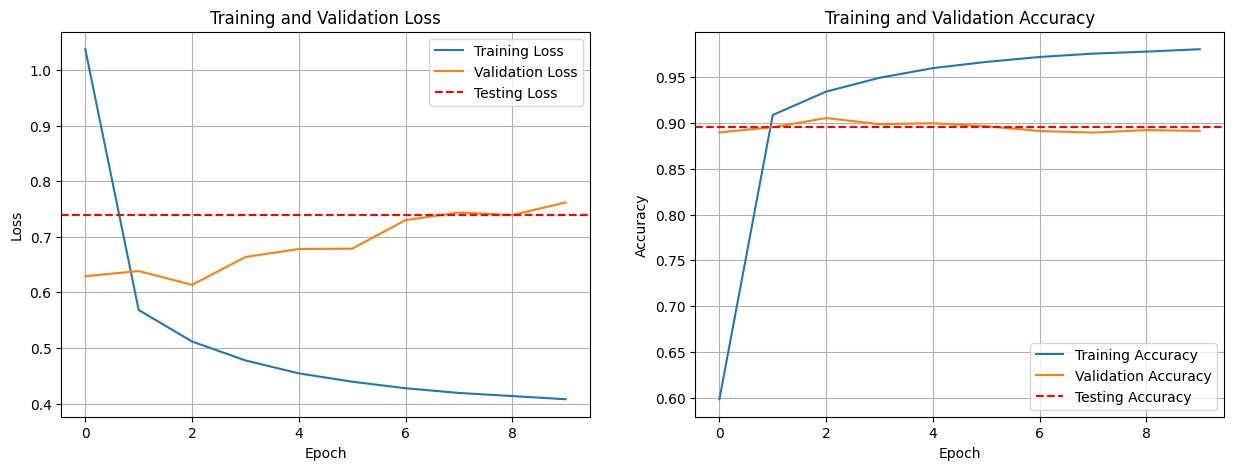

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.axhline(test_loss, label='Testing Loss',color='red',linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Training Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.axhline(test_acc, label='Testing Accuracy',color='red',linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)
plt.show()

In [49]:
base_model = model
base_model_train_accs = train_accs
base_model_val_accs = val_accs
base_model_test_acc = test_acc
base_model_train_losses = train_losses
base_model_val_losses = val_losses
base_model_test_loss = test_loss
base_model_all_labels = all_labels
base_model_all_preds = all_preds

## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [50]:
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim, 
    num_classes=num_classes,
    max_seq_length=max_seq_length,
    num_encoder_layers=2,
    num_heads=4,
    dropout=0.5,
    dim_feedforward=128,
    pretrained_embeddings=embedding_matrix
)

In [51]:
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)

In [52]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

In [53]:
early_stopping_patience = 3
num_epochs = 20

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [54]:
model.to(device)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
   
    # train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        src_key_padding_mask = create_padding_mask(input_ids).to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, src_key_padding_mask=src_key_padding_mask)
        loss = loss_function(outputs, labels - 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted + 1
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # train_bar.set_postfix(loss=loss.item())
    
    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    
    # val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            src_key_padding_mask = create_padding_mask(input_ids).to(device)
            outputs = model(input_ids, src_key_padding_mask=src_key_padding_mask)
            loss = loss_function(outputs, labels - 1)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            predicted = predicted + 1
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
            # val_bar.set_postfix(loss=loss.item())
    
    val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs} Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        best_model_state = model.state_dict()
    else:
        patience += 1
        
        if patience >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

Epoch 1/20 Training Loss: 1.1039, Training Accuracy: 0.5369 Validation Loss: 0.6602, Validation Accuracy: 0.8816
Epoch 2/20 Training Loss: 0.5907, Training Accuracy: 0.8982 Validation Loss: 0.6214, Validation Accuracy: 0.8984
Epoch 3/20 Training Loss: 0.5433, Training Accuracy: 0.9203 Validation Loss: 0.6223, Validation Accuracy: 0.8949
Epoch 4/20 Training Loss: 0.5177, Training Accuracy: 0.9318 Validation Loss: 0.6444, Validation Accuracy: 0.8970
Epoch 5/20 Training Loss: 0.5003, Training Accuracy: 0.9400 Validation Loss: 0.6637, Validation Accuracy: 0.8951
Early stopping triggered after 5 epochs


In [75]:
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

if best_model_state is not None:
    model.load_state_dict(best_model_state)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        src_key_padding_mask = create_padding_mask(input_ids).to(device)
        outputs = model(input_ids, src_key_padding_mask=src_key_padding_mask)
        loss = loss_function(outputs, labels - 1)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        predicted = predicted + 1
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = accuracy_score(all_labels, all_preds)

In [67]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6505
Test Accuracy: 0.8989


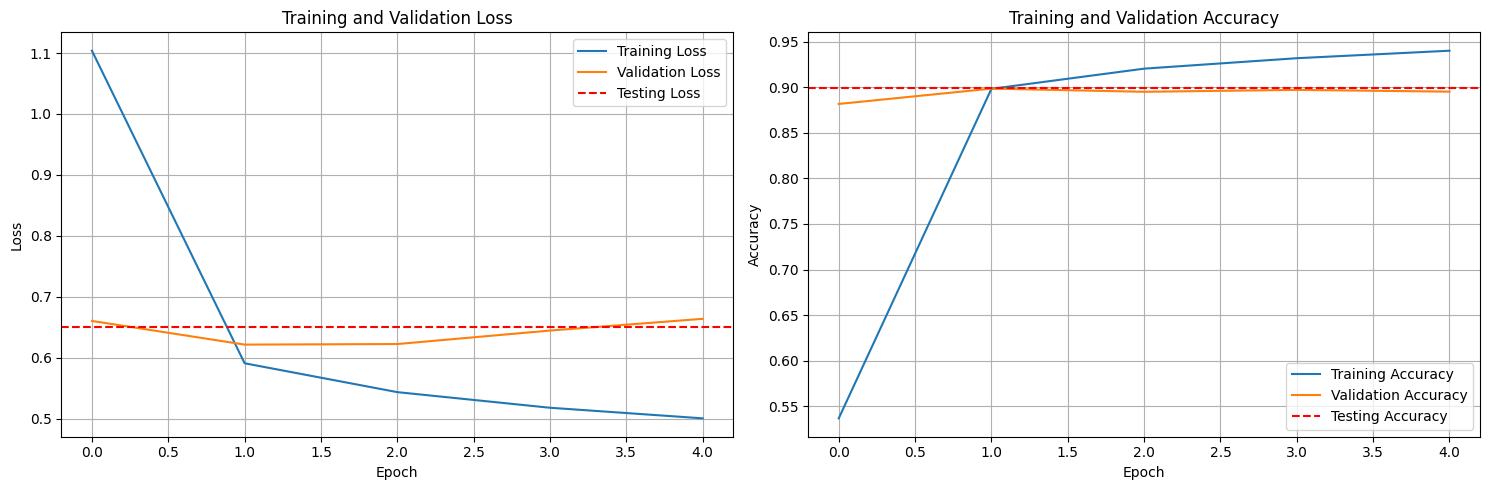

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.axhline(test_loss, label='Testing Loss',color='red',linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Training Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.axhline(test_acc, label='Testing Accuracy',color='red',linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

2. Discuss how the optimization techniques helped to improve the performance of the model.

<span style='color:green'>

The optimization techniques applied in the Improved Model — namely weight decay, early stopping, and a learning rate scheduler — contributed to better generalization and slightly improved test performance. 

1. Weight Decay (L2 Regularization): Penalizes large weights, encouraging the model to learn simpler, more general patterns. This helped reduce overfitting — although training loss didn't go as low as in the base model, validation loss remained more stable, especially early on.

2. Early Stopping: Stops training when validation performance stops improving, preventing overfitting. This stopped training at epoch 5, before the model could overfit. This preserved generalization ability and saved training time.

3. Learning Rate Scheduler: Gradually reduces the learning rate to allow fine-tuning of the model in later epochs. This allowed the model to converge more smoothly and avoid overshooting optimal weights, leading to more stable validation accuracy.

**Overall Performance Comparison**

| Model           | Validation Accuracy | Test Accuracy | Validation Loss | Test Loss       |
|-----------------|---------------------|---------------|-----------------|-----------------|
| Base Model      | 0.8914              | 0.8961        | 0.7618          | 0.7390          |
| Improved Model  | 0.8951              | 0.8989        | 0.6637          | 0.6505          |

The improved model trained for fewer epochs but achieved better test loss and accuracy. These techniques controlled overfitting and stabilized training, making the model more robust on unseen data.

</span>

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [ ]:
torch.save(model.state_dict(), "model.pt")

4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

In [73]:
print(f"Average Training Accuracy: {sum(train_accs)/len(train_accs):.4f}")
print(f"Average Training Loss: {sum(train_losses)/len(train_losses):.4f}")
print(f"Average Validation Accuracy: {sum(val_accs)/len(val_accs):.4f}")
print(f"Validation Loss: {sum(val_losses)/len(val_losses):.4f}")
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Average Training Accuracy: 0.8454
Average Training Loss: 0.6512
Average Validation Accuracy: 0.8934
Validation Loss: 0.6424
Testing Loss: 0.6505
Testing Accuracy: 0.8989


<span style='color:green'>

* High validation and testing accuracy (~89–90%) indicates strong generalization.
* Validation/test loss is slightly lower than training loss, showing effective regularization.
* The training accuracy is a bit lower than validation/test, possibly due to dropout or weight decay — which is a good sign of avoiding overfitting.
* Overall, the model is well-tuned and robust on unseen data.

</span>

b. Plot the training and validation accuracy over time (epochs).

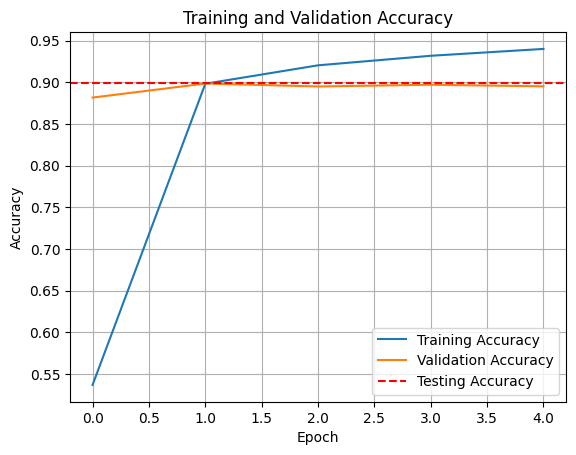

In [60]:
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.axhline(test_acc, label='Testing Accuracy',color='red',linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<span style='color:green'>

From the plot:

* Training Accuracy increases consistently and surpasses validation accuracy by epoch 2.
* Validation Accuracy improves slightly and remains stable.
* Testing Metrics stay close to validation metrics, suggesting good generalization.

</span>

   c. Plot the training and validation loss over time (epochs).


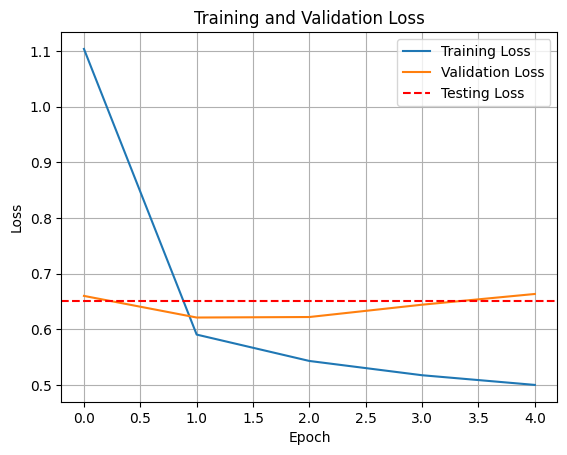

In [61]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(test_loss, label='Testing Loss',color='red',linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<span style='color:green'>

From the plot:

* Training Loss steadily decreases, showing effective learning.
* Validation Loss plateaus and starts to slightly rise after epoch 2, indicating early signs of overfitting.
* Testing Metrics stay close to validation metrics, suggesting good generalization.

</span>

   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


In [76]:
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.88      0.90      4709
           2       0.91      0.98      0.95      4917
           3       0.91      0.83      0.87      4740
           4       0.86      0.91      0.88      4774

    accuracy                           0.90     19140
   macro avg       0.90      0.90      0.90     19140
weighted avg       0.90      0.90      0.90     19140



<span style='color:green'>
The model performs excellently with 90% accuracy, and balanced precision, recall, and F1-scores (~0.90) across all classes. It shows strong generalization and consistent classification, indicating the model is well-trained and correctly configured for the multi-class task.
</span>

   e. Plot the ROC curve.

In [ ]:
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        mask = create_padding_mask(input_ids).to(device)

        outputs = model(input_ids, src_key_padding_mask=mask)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

all_probs = torch.cat(all_probs, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()


In [ ]:
from sklearn.preprocessing import label_binarize

all_labels = all_labels - 1  
num_classes = 4
all_labels_onehot = label_binarize(all_labels, classes=list(range(num_classes)))


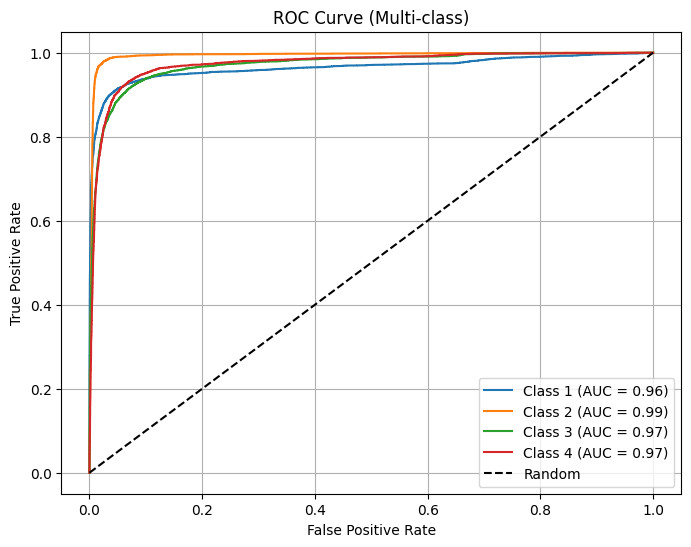

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<span style='color:green'>
The ROC curves show high AUC scores (≥ 0.96) for all classes, indicating excellent model performance and strong ability to distinguish between classes.
</span>